In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import KFold, train_test_split

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP/Data/processed_data.csv')

In [ ]:
# Dữ liệu
X = df['sent_tokens']  # Các câu tokenized
y = df['Label']  # Nhãn

# Sử dụng TfidfVectorizer
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X).toarray()

In [ ]:
# Chia dữ liệu thành tập train
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.05, random_state=42)

# Hàm tạo mô hình biLSTM
def create_bilstm_model_tfidf(input_length):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_length,)),  # Input phù hợp
        tf.keras.layers.Dense(128, activation='relu'),  # Lớp Dense với 128 nút
        tf.keras.layers.Dropout(0.5),  # Dropout để giảm overfitting
        tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer cho phân loại nhị phân
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Số splits của K-Fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

fold_metrics = []
input_length = X_train.shape[1]

model = create_bilstm_model_tfidf(input_length=input_length)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train), start=1):
    # Chia train và validation
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Huấn luyện mô hình trên tập train
    model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=32, verbose=0, validation_data=(X_val_fold, y_val_fold))

    # Dự đoán trên tập validation
    y_val_pred = (model.predict(X_val_fold) > 0.5).astype(int)

    # Tính các chỉ số đánh giá
    precision = precision_score(y_val_fold, y_val_pred, pos_label = 0)
    recall = recall_score(y_val_fold, y_val_pred, pos_label = 0)
    f1 = f1_score(y_val_fold, y_val_pred, pos_label = 0)

    # Lưu các chỉ số
    fold_metrics.append({'fold': fold, 'precision': precision, 'recall': recall, 'f1': f1})
    print(f"Fold {fold}: Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}")

# Tính trung bình các chỉ số
avg_precision = np.mean([metrics['precision'] for metrics in fold_metrics])
avg_recall = np.mean([metrics['recall'] for metrics in fold_metrics])
avg_f1 = np.mean([metrics['f1'] for metrics in fold_metrics])

print(f"\nChỉ số trung bình: Precision={avg_precision:.4f}, Recall={avg_recall:.4f}, F1-Score={avg_f1:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Fold 1: Precision=0.9153, Recall=0.6506, F1-Score=0.7606
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 2: Precision=0.9178, Recall=0.9710, F1-Score=0.9437
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 3: Precision=0.9865, Recall=0.9605, F1-Score=0.9733
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 4: Precision=1.0000, Recall=1.0000, F1-Score=1.0000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 5: Precision=1.0000, Recall=0.9867, F1-Score=0.9933

Chỉ số trung bình: Precision=0.9639, Recall=0.9138, F1-Score=0.9342


In [ ]:
# Dự đoán trên tập test
y_test_pred = (model.predict(X_test) > 0.5).astype(int)

# Tính chỉ số trên tập test
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"\nKết quả trên tập test: Precision={test_precision:.4f}, Recall={test_recall:.4f}, F1-Score={test_f1:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Kết quả trên tập test: Precision=0.8276, Recall=0.8889, F1-Score=0.8571


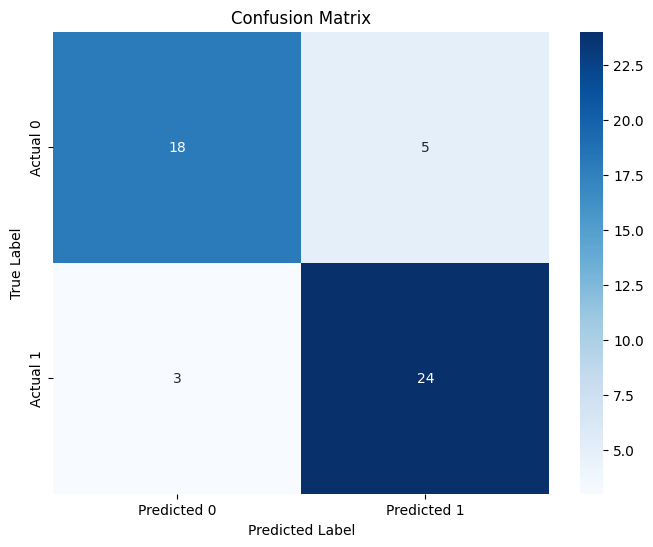

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
import pickle

# Lưu model
filename = '/content/drive/MyDrive/NLP/Models/biLSTM_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
filename = '/content/drive/MyDrive/NLP/Models/tfidf_vectorizer.sav'
pickle.dump(vectorizer, open(filename, 'wb'))